In [ ]:
#Lab Glassware

In [ ]:
# Instalação de bibliotecas essenciais
!pip install roboflow
!pip install tensorflow
!pip install opencv-python
!pip install matplotlib
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 60.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
# Importação das bibliotecas
import os
import cv2
import torch
import json
import pandas as pd
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
from torchvision import transforms
from torch.utils.data import DataLoader
from roboflow import Roboflow
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim as optim
from tqdm import tqdm



In [ ]:
# Conexão com dataset de vidrarias de laboratório via Roboflow
rf = Roboflow(api_key="mpV6g84DqvN6HUqz9mt1")
project = rf.workspace("lab-identification").project("lab-identification-y2nq4")
version = project.version(11)
dataset = version.download("coco")  # formato compatível com PyTorch


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to LAB-IDENTIFICATION-11 in coco:: 100%|██████████| 4003/4003 [00:01<00:00, 3018.97it/s]


In [ ]:
# Hiperparâmetros para treinamento
BATCH_SIZE = 2
IMAGE_SIZE = 640  # conforme o pré-processamento do dataset
EPOCHS = 7
LEARNING_RATE = 0.0001


In [ ]:
# Bloco para seleção de dispositivo (CUDA, MPS ou CPU)
if torch.cuda.is_available():
    # Prioridade 1: GPU NVIDIA (CUDA)
    device = torch.device("cuda")
    print("Dispositivo selecionado: GPU NVIDIA (CUDA)")

elif torch.backends.mps.is_available():
    # Prioridade 2: GPU Apple (MPS)
    device = torch.device("mps")
    print("Dispositivo selecionado: GPU Apple (MPS)")

else:
    # Fallback: CPU
    device = torch.device("cpu")
    print("Dispositivo selecionado: CPU")

print(f'Usando dispositivo: {device}')


Dispositivo selecionado: GPU NVIDIA (CUDA)
Usando dispositivo: cuda


In [ ]:
# Definir as transformações para os dados
transformacoes = transforms.Compose([
    transforms.ToTensor(),  # Converte para tensor e escala para [0, 1]
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Média dos canais RGB
                         #std=[0.229, 0.224, 0.225])   # Desvio padrão dos canais RGB
])




In [ ]:
import json
from collections import defaultdict

def preparar_anotacoes_coco(json_path):
    with open(json_path) as f:
        coco = json.load(f)

    # Mapear categorias para índices
    categories = coco["categories"]
    class_to_idx = {cat["name"]: cat["id"] for cat in categories}

    # Mapear ID da imagem para nome do arquivo
    id_to_filename = {img["id"]: img["file_name"] for img in coco["images"]}

    # Agrupar anotações por imagem
    grouped = defaultdict(lambda: {"boxes": [], "labels": []})
    for ann in coco["annotations"]:
        image_id = ann["image_id"]
        filename = id_to_filename[image_id]
        x, y, w, h = ann["bbox"]
        box = [x, y, x + w, y + h]
        label = ann["category_id"]

        grouped[filename]["boxes"].append(box)
        grouped[filename]["labels"].append(label)

    # Lista final de anotações
    annotations = [
        {
            "filename": fname,
            "boxes": grouped[fname]["boxes"],
            "labels": grouped[fname]["labels"]
        }
        for fname in grouped
    ]

    return annotations, class_to_idx

In [ ]:
# Classe personalizada
class LabGlasswareDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, annotations, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        img_path = os.path.join(self.image_dir, ann["filename"])
        image = Image.open(img_path).convert("RGB")

        boxes = torch.tensor(ann["boxes"], dtype=torch.float32)
        labels = torch.tensor(ann["labels"], dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels
        }

        if self.transform:
            image = self.transform(image)

        return image, target



In [ ]:
# Diretórios
base_dir = "/content/LAB-IDENTIFICATION-11"
paths = {
    "train": os.path.join(base_dir, "train"),
    "valid": os.path.join(base_dir, "valid"),
    "test": os.path.join(base_dir, "test")
}


In [ ]:
# Anotações
annotations_train, class_to_idx = preparar_anotacoes_coco(os.path.join(paths["train"], "_annotations.coco.json"))
annotations_valid, _ = preparar_anotacoes_coco(os.path.join(paths["valid"], "_annotations.coco.json"))
annotations_test, _ = preparar_anotacoes_coco(os.path.join(paths["test"], "_annotations.coco.json"))

# Datasets
dataset_treino = LabGlasswareDataset(paths["train"], annotations_train, transformacoes)
dataset_validacao = LabGlasswareDataset(paths["valid"], annotations_valid, transformacoes)
dataset_teste = LabGlasswareDataset(paths["test"], annotations_test, transformacoes)

dataloader_treino = DataLoader(dataset_treino, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
dataloader_validacao = DataLoader(dataset_validacao, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
dataloader_teste = DataLoader(dataset_teste, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [ ]:
# DataLoaders
dataloader_treino = DataLoader(dataset_treino, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
dataloader_validacao = DataLoader(dataset_validacao, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
dataloader_teste = DataLoader(dataset_teste, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [ ]:
# Criar o modelo com número de classes personalizado

# Número de classes (inclui fundo = 0)
NUM_CLASSES = len(class_to_idx) + 1

# Carregar modelo pré-treinado
modelo = fasterrcnn_resnet50_fpn(pretrained=True)

# Substituir o cabeçote de classificação
in_features = modelo.roi_heads.box_predictor.cls_score.in_features
modelo.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

# Enviar para o dispositivo
modelo.to(device)


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 195MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# Definir otimizador e função de perda
import torch.optim as optim

params = [p for p in modelo.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005)


In [ ]:
# Loop de treinamento

modelo.train()

for epoch in range(EPOCHS):
    print(f"\n🔁 Época {epoch+1}/{EPOCHS}")
    epoch_loss = 0.0

    # === LOOP DE TREINAMENTO ===
    for images, targets in tqdm(dataloader_treino, desc=f"Treinando época {epoch+1}"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Cálculo da perda
        loss_dict = modelo(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Acumular perda total
        epoch_loss += losses.item()

    # Média da perda da época
    epoch_loss /= len(dataloader_treino)
    print(f"📉 Loss médio de treino na época {epoch+1}: {epoch_loss:.4f}")

    # === LOOP DE VALIDAÇÃO ===
    modelo.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, targets in tqdm(dataloader_validacao, desc="Validando"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = modelo(images, targets)
            if isinstance(loss_dict, dict):
                losses = sum(loss for loss in loss_dict.values())
                val_loss += losses.item()

    val_loss /= len(dataloader_validacao)
    print(f"✅ Loss médio de validação: {val_loss:.4f}")
    modelo.train()




🔁 Época 1/7


Treinando época 1: 100%|██████████| 1749/1749 [11:43<00:00,  2.49it/s]


📉 Loss médio de treino na época 1: 0.3235


Validando: 100%|██████████| 166/166 [00:29<00:00,  5.55it/s]


✅ Loss médio de validação: 0.0000

🔁 Época 2/7


Treinando época 2: 100%|██████████| 1749/1749 [11:44<00:00,  2.48it/s]


📉 Loss médio de treino na época 2: 0.2330


Validando: 100%|██████████| 166/166 [00:30<00:00,  5.47it/s]


✅ Loss médio de validação: 0.0000

🔁 Época 3/7


Treinando época 3: 100%|██████████| 1749/1749 [11:47<00:00,  2.47it/s]


📉 Loss médio de treino na época 3: 0.1774


Validando: 100%|██████████| 166/166 [00:29<00:00,  5.54it/s]


✅ Loss médio de validação: 0.0000

🔁 Época 4/7


Treinando época 4: 100%|██████████| 1749/1749 [11:46<00:00,  2.48it/s]


📉 Loss médio de treino na época 4: 0.1427


Validando: 100%|██████████| 166/166 [00:30<00:00,  5.45it/s]


✅ Loss médio de validação: 0.0000

🔁 Época 5/7


Treinando época 5: 100%|██████████| 1749/1749 [11:47<00:00,  2.47it/s]


📉 Loss médio de treino na época 5: 0.1232


Validando: 100%|██████████| 166/166 [00:30<00:00,  5.49it/s]


✅ Loss médio de validação: 0.0000

🔁 Época 6/7


Treinando época 6: 100%|██████████| 1749/1749 [11:46<00:00,  2.47it/s]


📉 Loss médio de treino na época 6: 0.1119


Validando: 100%|██████████| 166/166 [00:30<00:00,  5.45it/s]


✅ Loss médio de validação: 0.0000

🔁 Época 7/7


Treinando época 7: 100%|██████████| 1749/1749 [11:47<00:00,  2.47it/s]


📉 Loss médio de treino na época 7: 0.1033


Validando: 100%|██████████| 166/166 [00:30<00:00,  5.44it/s]

✅ Loss médio de validação: 0.0000


In [ ]:
# Salvar o modelo treinado

torch.save(modelo.state_dict(), "modelo_labglassware.pth")
print("✅ Modelo salvo como modelo_labglassware.pth")


✅ Modelo salvo como modelo_labglassware.pth



🔍 Resultados da detecção:

Classe: beaker               | Confiança: 0.99
Classe: beaker               | Confiança: 0.75
Classe: erlenmeyer_flask     | Confiança: 0.62


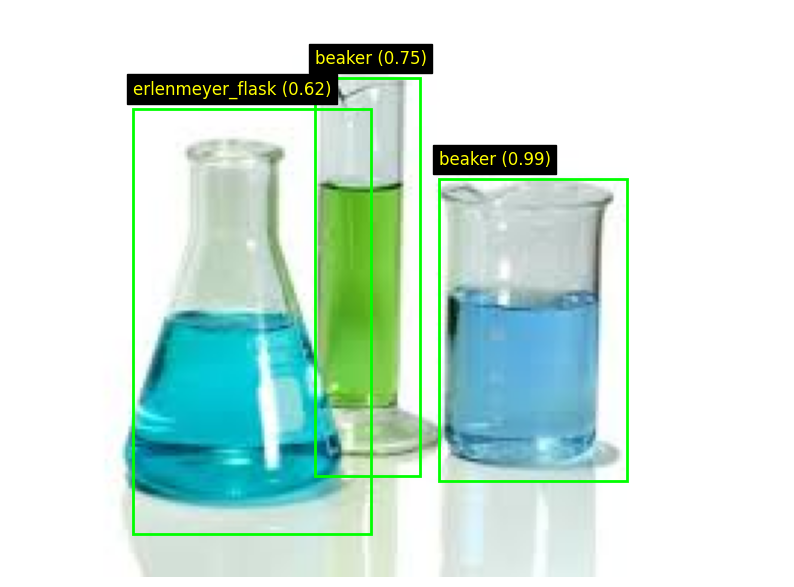

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision

# ====== CONFIGURAÇÕES ======
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Caminho do modelo treinado (.pth)
PATH_MODELO = "modelo_labglassware.pth"  # ajuste para o nome/caminho real

# Caminho da imagem para teste (fora do dataset)
IMAGEM_TESTE = "Varios2.jpeg"  # substitua pelo caminho real

# ====== CLASSES ======
CLASSES = [
    "background",             # 0
    "beaker",                 # 1
    "compass",                # 2
    "digital_balance",        # 3
    "erlenmeyer_flask",       # 4
    "funnel",                 # 5
    "graduated_cylinder",     # 6
    "horseshoe_magnet",       # 7
    "objects",                # 8
    "stirring_rod",           # 9
    "test_tube",              # 10
    "test_tube_rack",         # 11
    "thermometer",            # 12


]

NUM_CLASSES = len(CLASSES)

# ====== 1️⃣ Carregar o modelo ======
modelo = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, num_classes=NUM_CLASSES)
modelo.load_state_dict(torch.load(PATH_MODELO, map_location=device))
modelo.to(device)
modelo.eval()

# ====== 2️⃣ Transformar a imagem ======
transform = transforms.Compose([
    transforms.ToTensor(),
])

imagem = Image.open(IMAGEM_TESTE).convert("RGB")
img_tensor = transform(imagem).to(device)

# ====== 3️⃣ Fazer a predição ======
with torch.no_grad():
    outputs = modelo([img_tensor])

# ====== 4️⃣ Processar resultados ======
output = outputs[0]
boxes = output['boxes']
labels = output['labels']
scores = output['scores']

# Limite mínimo de confiança
threshold = 0.6

indices = [i for i, s in enumerate(scores) if s > threshold]

print("\n🔍 Resultados da detecção:\n")
for i in indices:
    classe_nome = CLASSES[labels[i].item()]
    confianca = scores[i].item()
    print(f"Classe: {classe_nome:<20} | Confiança: {confianca:.2f}")

# ====== 5️⃣ Exibir imagem com bounding boxes ======
fig, ax = plt.subplots(1, figsize=(10,10))
ax.imshow(imagem)

for i in indices:
    box = boxes[i].cpu().numpy()
    x1, y1, x2, y2 = box
    classe_nome = CLASSES[labels[i].item()]
    conf = scores[i].item()

    ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                               fill=False, color='lime', linewidth=2))
    ax.text(x1, y1 - 5, f"{classe_nome} ({conf:.2f})",
            color='yellow', fontsize=12, backgroundcolor='black')

plt.axis("off")
plt.show()
